In [129]:
import os
BASE = "/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/"
sqt_files_path = os.path.join(BASE,'*.sqt')
dtaselect_path = os.path.join(BASE,'DTASelect_p2_pfp/DTASelect-filter.txt')
from glob import glob
from metaproteomics.file_processing import blazmass_tools
from tqdm import tqdm
from pymongo import MongoClient
from itertools import chain
import matplotlib.pyplot as plt
client = MongoClient('localhost', 27018)
ProtDB = client['ProtDB_072114']['ProtDB_072114']
SeqDB = client['SeqDB_072114']['SeqDB_072114']

In [19]:
%matplotlib inline
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

In [20]:
sqt_files = glob(sqt_files_path)
sqt_files

['/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_12.sqt',
 '/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_11.sqt',
 '/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_08.sqt',
 '/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_07.sqt',
 '/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_10.sqt',
 '/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_01.sqt',
 '/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_04.sqt',
 '/mon

In [30]:
sqt_file = '/mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_12.sqt'
parser = blazmass_tools.sqt_chunker(sqt_file)
next(parser).keys()

dict_keys(['#seq_matching', 'matches', 'high_scan', 'Xcorr', 'total_intensity', 'charge', 'process_time', 'obs_mass', 'server', 'low_scan', 'deltCN', 'lowest_SP'])

In [85]:
def get_xcorrs_deltacns_from_sqt(sqt_file):

    all_scan_info = []
    
    print('Parsing {}...'.format(os.path.basename(sqt_file)))
    parser = blazmass_tools.sqt_chunker(sqt_file)
    for record in parser:
        record_dict = {}
        record_dict['Xcorr'] = record['Xcorr']
        record_dict['deltCN'] = record['deltCN']

        first_match = record['matches'][0]
        first_peptide_match = first_match['seq_matched'].split('.',1)[1].rsplit('.',1)[0]
        record_dict['peptide'] = first_peptide_match
        record_dict['reverse'] = first_match['reverse']
        all_scan_info.append(record_dict)
    
    get_parents(all_scan_info)
    return all_scan_info

def get_parents(all_scan_info):
    seq_results = list(SeqDB.find({'_id':{'$in':list(set([x['peptide'] for x in all_scan_info]))}}))
    all_parents = set(chain(*[[x['i'] for x in result['p']] for result in seq_results]))
    prot_dict = {x['_id']:x.get('o','') for x in ProtDB.find({'_id':{'$in':list(all_parents)}}, {'o':True})}
    
    for result in seq_results:
        peptide = result['_id']
        parents = [x['i'] for x in result['p']]
        organisms = [prot_dict[p] for p in parents]
        for scan in all_scan_info:
            if scan['peptide'] == peptide:
                scan['organisms'] = organisms

In [89]:
all_scan_info = list(map(get_xcorrs_deltacns_from_sqt, sqt_files))

Parsing /mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_12.sqt...
Parsing /mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_11.sqt...
Parsing /mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_08.sqt...
Parsing /mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_07.sqt...
Parsing /mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_10.sqt...
Parsing /mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/102214_SC_HEK293_25ug_HCD_FTMS_MS2_01.sqt...
Parsing /mongoa/DTASelect/10_2014_mass_spec/102214_HEK293_HCD35/indexDB_search_noProtDB_30ppm_50ppmfrag/10

In [91]:
flat_scan_info = list(chain(*all_scan_info))
print(len(flat_scan_info))

236846


In [93]:
def contains_human(scan):
    return True if any('homo sapien' in organism.lower() for organism in scan.get('organisms',[])) else False

In [95]:
forward_human_scans = [scan for scan in flat_scan_info if contains_human(scan) and not scan['reverse']]
forward_nonhuman_scans = [scan for scan in flat_scan_info if not contains_human(scan) and not scan['reverse']]
reverse_scans = [scan for scan in flat_scan_info if scan['reverse']]
[len(x) for x in (forward_human_scans, forward_nonhuman_scans, reverse_scans)]

[104979, 65767, 66100]

In [162]:
# Get filtered scans

dta_parser = blazmass_tools.dta_select_parser(dtaselect_path)
seen = set()
filtered_scan_info = []
for locus in dta_parser:
    for peptide in locus['peptides']:
        scan_id = "{}_{}".format(peptide['LCStep'],peptide['Scan'])
        if scan_id not in seen:
            seen.add(scan_id)
            filtered_scan_info.append({"peptide":peptide['aa_sequence'], 
                                       "Xcorr": peptide['XCorr'], 
                                       "deltCN": peptide['DeltCN'],
                                       "reverse": locus['reverse']})

get_parents(filtered_scan_info)
filtered_scan_info[:10]

[{'Xcorr': 3.1468947,
  'deltCN': 0.16411096,
  'organisms': ['Homo sapiens'],
  'peptide': 'MRYVASYLLAALGGNSSPSAK',
  'reverse': False},
 {'Xcorr': 4.160022,
  'deltCN': 0.4879791,
  'organisms': ['Homo sapiens'],
  'peptide': 'YVASYLLAALGGNSSPSAK',
  'reverse': False},
 {'Xcorr': 3.3421335,
  'deltCN': 0.15390891,
  'organisms': ['Homo sapiens'],
  'peptide': 'YVASYLLAALGGNSSPSAK',
  'reverse': False},
 {'Xcorr': 6.1183476,
  'deltCN': 0.39672804,
  'organisms': ['Homo sapiens'],
  'peptide': 'KILDSVGIEADDDRLNK',
  'reverse': False},
 {'Xcorr': 5.9300942,
  'deltCN': 0.37054288,
  'organisms': ['Homo sapiens'],
  'peptide': 'KILDSVGIEADDDRLNK',
  'reverse': False},
 {'Xcorr': 4.3299627,
  'deltCN': 0.27638614,
  'organisms': ['Homo sapiens'],
  'peptide': 'KILDSVGIEADDDRLNK',
  'reverse': False},
 {'Xcorr': 3.4427617,
  'deltCN': 0.2315278,
  'organisms': ['Homo sapiens'],
  'peptide': 'ILDSVGIEADDDR',
  'reverse': False},
 {'Xcorr': 4.967953,
  'deltCN': 0.36131066,
  'organisms': [

In [163]:
filtered_human_scans = [scan for scan in filtered_scan_info if contains_human(scan) and not scan['reverse']]
filtered_nonhuman_scans = [scan for scan in filtered_scan_info if not contains_human(scan) and not scan['reverse']]
filtered_reverse_scans = [scan for scan in filtered_scan_info if scan['reverse']]

[len(x) for x in (filtered_human_scans, filtered_nonhuman_scans, filtered_reverse_scans)]

[26767, 251, 62]

## formatting

In [184]:
import matplotlib.font_manager as fm
fpath = '/usr/share/fonts/helvetica/HelveticaNeue.ttf'
prop38 = fm.FontProperties(fname=fpath, size=38)
prop24 = fm.FontProperties(fname=fpath, size=24)
prop16 = fm.FontProperties(fname=fpath, size=16)
prop15 = fm.FontProperties(fname=fpath, size=15)
prop12 = fm.FontProperties(fname=fpath, size=12)
circlearea = 1
legend_marker_size = 5
opacity = 0.8
colors = {}
colors['forward_human'] = '#468966'
colors['forward_nonhuman'] = '#FFF0A5'
colors['reverse'] = '#FFB03B'
colors['filtered'] = '#B64926'

# save files as png, jpg, or pdf (PNG and PDF are complex with so many datapoints)
file_extension = '.jpg'

In [187]:
def plot_subfig(fig, n, xcorrs, deltacns, label, color):
    ax = fig.add_subplot(2,3,n)
    ax.scatter(xcorrs, deltacns, c = color, alpha = opacity, label = label, lw=0.1, s=circlearea)
    ax.set_xlabel('XCorr', fontproperties=prop12)
    ax.set_ylabel('DeltaCN', fontproperties=prop12)
    for label in ax.get_yticklabels():
        label.set_fontproperties(prop12)
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop12)
    ax.set_xlim(left = 0, right = 10)
    ax.set_ylim(bottom = 0, top = 1.0)
    ax.legend(loc='upper right', prop=prop15, markerscale=legend_marker_size, fancybox=True)

def plot_overlay_subfig(fig, n, list_scans, labels, colors):
    ax = fig.add_subplot(2,3,n)
    for scans, color, label in zip(list_scans, colors, labels):
        ax.scatter([scan['Xcorr'] for scan in scans], [scan['deltCN'] for scan in scans], c = color, alpha = opacity, label = label, lw=0.1, s=circlearea)
        
    ax.set_xlabel('XCorr', fontproperties=prop24)
    ax.set_ylabel('DeltaCN', fontproperties=prop24)
    for label in ax.get_yticklabels():
        label.set_fontproperties(prop16)
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop16)
    ax.set_xlim(left = 0, right = 10)
    ax.set_ylim(bottom = 0, top = 1.0)
    ax.legend(loc='upper right', prop=prop16, markerscale=legend_marker_size, fancybox=True)


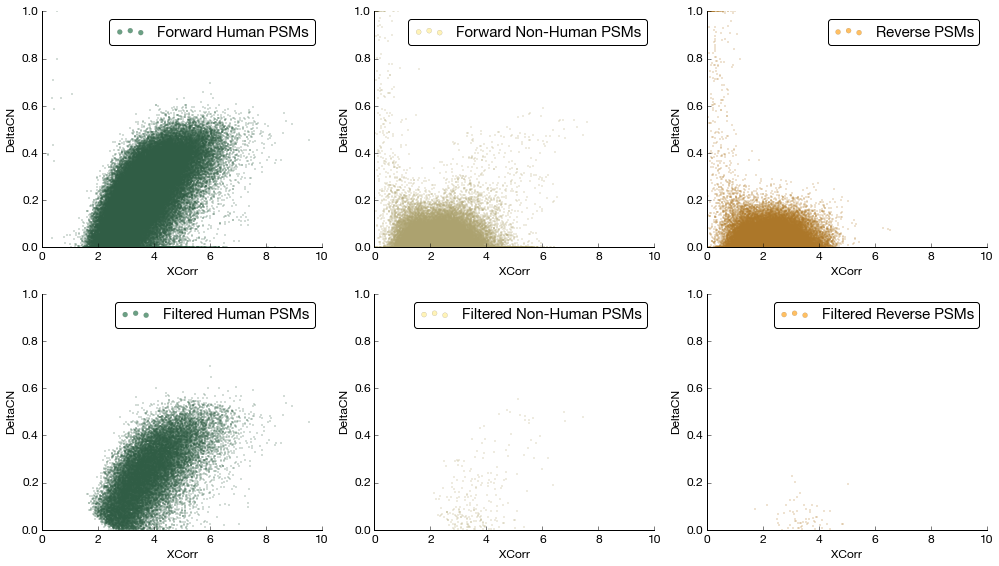

In [195]:
fig = plt.figure(figsize=(14,8))
forward_human_xcorrs = [scan['Xcorr'] for scan in forward_human_scans]
forward_human_deltacns = [scan['deltCN'] for scan in forward_human_scans]
plot_subfig(fig, 1, forward_human_xcorrs, forward_human_deltacns, 'Forward Human PSMs', color=colors['forward_human'])
ax = fig.axes[0]
remove_border(fig.axes[0])
#ax.text(-0.15,1.1,"a", transform=ax.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

forward_nonhuman_xcorrs = [scan['Xcorr'] for scan in forward_nonhuman_scans]
forward_nonhuman_deltacns = [scan['deltCN'] for scan in forward_nonhuman_scans]
plot_subfig(fig, 2, forward_nonhuman_xcorrs, forward_nonhuman_deltacns, 'Forward Non-Human PSMs', color=colors['forward_nonhuman'])
remove_border(fig.axes[1])

reverse_xcorrs = [scan['Xcorr'] for scan in reverse_scans]
reverse_deltacns = [scan['deltCN'] for scan in reverse_scans]
plot_subfig(fig, 3, reverse_xcorrs, reverse_deltacns, 'Reverse PSMs', color=colors['reverse'])
remove_border(fig.axes[2])

fh_xcorrs = [scan['Xcorr'] for scan in filtered_human_scans]
fh_deltacns = [scan['deltCN'] for scan in filtered_human_scans]
plot_subfig(fig, 4, fh_xcorrs, fh_deltacns, 'Filtered Human PSMs', color=colors['forward_human'])
ax = fig.axes[3]
remove_border(fig.axes[3])
#ax.text(-0.15,1.1,"b", transform=ax.transAxes,fontsize=20, fontweight='bold', va='top', ha='right')

fnh_xcorrs = [scan['Xcorr'] for scan in filtered_nonhuman_scans]
fnh_deltacns = [scan['deltCN'] for scan in filtered_nonhuman_scans]
plot_subfig(fig, 5, fnh_xcorrs, fnh_deltacns, 'Filtered Non-Human PSMs', color=colors['forward_nonhuman'])
remove_border(fig.axes[4])

fr_xcorrs = [scan['Xcorr'] for scan in filtered_reverse_scans]
fr_deltacns = [scan['deltCN'] for scan in filtered_reverse_scans]
plot_subfig(fig, 6, fr_xcorrs, fr_deltacns, 'Filtered Reverse PSMs', color=colors['reverse'])
remove_border(fig.axes[5])

"""
labels = ['Filtered Human PSMs', 'Filtered Non-Human PSMs']
colors = ['r','b']
plot_overlay_subfig(fig, 6, [filtered_human_scans, filtered_nonhuman_scans], labels, colors)
"""
#
plt.tight_layout()
plt.savefig("HEK293_indexDB_XCorr_DeltaCN_Figure2B.pdf")
plt.savefig("HEK293_indexDB_XCorr_DeltaCN_Figure2B.png", dpi=300)